# Notebook 4: GRPO Reasoning Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BalaAnbalagan/modern-ai-unsloth/blob/main/colab4_grpo_reasoning.ipynb)

**Author**: Balamuralikrishnan Anbalagan  
**Objective**: Demonstrate reasoning training with GRPO on GSM8K math data source

---

## Overview
In this runbook demonstrates **Group Relative Policy Optimization (GRPO)** for reasoning tasks. We'll:
- Use GSM8K data source (grade school math problems)
- Train model to show explicit reasoning before answering
- Implement custom reward function for math accuracy
- Measure accuracy improvement before/after training
- Generate structured reasoning outputs\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

## 1. Installation & Setup\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [1]:
%%capture
# Install Unsloth and dependencies
# What's happening: Installing libraries for reinforcement learning-based training
# Key libraries for GRPO:
#   - unsloth: Optimizes RL training (faster policy updates, efficient sampling)
#   - trl: Contains trainers for RL methods (PPO, GRPO, etc.)
#   - peft: LoRA implementation for parameter-efficient RL fine-tuning
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
# Verify GPU availability
# What's happening: Checking GPU for RL training
# GRPO note: Requires less memory than PPO (no value function network needed)
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
GPU Memory: 39.56 GB
BF16 Support: True


## 2. Load & Prepare GSM8K Dataset

GSM8K contains 8.5K grade school math problems requiring multi-step reasoning\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [4]:
# === Data: ASDiv (new dataset, robust loader) ===
from datasets import load_dataset
import re
import random

# Try a few public datasets in order; stop at the first that loads.
CANDIDATE_DATASETS = [
    ("EleutherAI/asdiv", None),       # ASDiv (preferred)
    ("yimingzhang/asdiv", None),      # ASDiv mirror
    ("openai/gsm8k", "main"),         # GSM8K
    ("allenai/math_qa", None),        # MathQA (multiple-choice)
]

def try_load_dataset(candidates):
    last_err = None
    for path, subset in candidates:
        try:
            print(f"Trying to load: {path}" + (f" / {subset}" if subset else ""))
            ds = load_dataset(path, subset, split="train")
            print(f"Loaded: {path}" + (f" / {subset}" if subset else ""), "size:", len(ds))
            return path, subset, ds
        except Exception as e:
            last_err = e
            print(f"Failed: {path}", e)
    raise last_err

ds_name, ds_subset, raw = try_load_dataset(CANDIDATE_DATASETS)

# Keep a manageable subset for quick demos
try:
    sample_n = cfg.train_sample_size if hasattr(cfg, "train_sample_size") else 800
except:
    sample_n = 800
if sample_n and sample_n < len(raw):
    raw = raw.shuffle(seed=42).select(range(sample_n))

SYSTEM = "You are a careful math tutor. Show brief reasoning, then finish with: Final Answer: <number>."

# Heuristics to pick question/answer keys across variants
QUESTION_CANDIDATES = ["question", "Question", "body", "Body", "text", "Text", "Problem", "problem"]
ANSWER_CANDIDATES   = ["answer", "Answer", "ans", "Ans", "final_answer", "FinalAnswer", "label", "result", "Result", "solution", "Solution"]

def pick_key(example, keys):
    for k in keys:
        if k in example and example[k] is not None:
            return k
    return None

def normalize_gold(answer_field):
    # Extract a number if possible; fallback to raw text
    if answer_field is None:
        return ""
    s = str(answer_field)
    m = re.search(r"([-+]?\\d+(?:\\.\\d+)?)", s.replace(",", ""))  # strip commas like 1,234
    return m.group(1) if m else s.strip()

def to_prompt(example):
    qk = pick_key(example, QUESTION_CANDIDATES)
    ak = pick_key(example, ANSWER_CANDIDATES)
    q = example.get(qk, "") if qk else ""
    a = example.get(ak, "") if ak else ""

    # MathQA is multiple-choice; its golden answer can be a letter. We still keep it,
    # but our reward prefers numeric matches. That’s fine for GRPO demos; for MC tasks
    # you could change the reward later to check the correct option letter.
    gold = normalize_gold(a)

    messages = [
        {"role": "system", "content": SYSTEM},
        {"role": "user", "content": f"Solve the problem and end with 'Final Answer: <number>'.\\n\\n{q}"}
    ]
    return {"messages": messages, "answer": gold}

ds = raw.map(to_prompt, remove_columns=[c for c in raw.column_names if c not in ["messages","answer"]])
print("Example mapped row:", ds[0])


Trying to load: EleutherAI/asdiv


README.md:   0%|          | 0.00/494 [00:00<?, ?B/s]

asdiv/validation-00000-of-00001.parquet:   0%|          | 0.00/267k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2305 [00:00<?, ? examples/s]

Failed: EleutherAI/asdiv Unknown split "train". Should be one of ['validation'].
Trying to load: yimingzhang/asdiv


README.md:   0%|          | 0.00/442 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/131k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/34.3k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/301 [00:00<?, ? examples/s]

Loaded: yimingzhang/asdiv size: 1200


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Example mapped row: {'messages': [{'content': 'You are a careful math tutor. Show brief reasoning, then finish with: Final Answer: <number>.', 'role': 'system'}, {'content': "Solve the problem and end with 'Final Answer: <number>'.\\n\\nQuestion: A pet supply store has 600 bags of dog food and 327 bags of cat food. How many more bags of dog food are there than cat food?\nAnswer:", 'role': 'user'}], 'answer': '273'}


In [9]:
# ===== Robust split + formatting for GRPO (GSM8K / ASDiv / MathQA compatible) =====
import re

# 0) Use the dataset you already loaded earlier
print("Preparing train/test splits...")
if "ds" in locals():
    base = ds
elif "raw" in locals():
    base = raw
else:
    raise ValueError("No dataset found. Make sure the data-loading cell ran (it should define `ds` or `raw`).")

# If you already have a split, keep it; otherwise make one
if "train" in base and "test" in base:
    train_dataset = base["train"]
    test_dataset  = base["test"]
else:
    split = base.train_test_split(test_size=0.1, seed=42)
    train_dataset = split["train"]
    test_dataset  = split["test"]
print(f"✓ Split complete: train={len(train_dataset)}  test={len(test_dataset)}")

# 1) Define SYSTEM if not already set
if "SYSTEM" not in globals():
    SYSTEM = (
        "You are a friendly, careful math tutor. "
        "Think step by step and finish your response with: Final Answer: <number>."
    )

# 2) Guess column names across datasets
QUESTION_KEYS = ["question", "Question", "body", "Body", "text", "Text", "Problem", "problem", "prompt"]
ANSWER_KEYS   = ["answer", "Answer", "ans", "Ans", "final_answer", "FinalAnswer", "label", "result", "Result", "solution", "Solution"]

# 3) Extract an answer that GRPO can score
def extract_answer_text(ans):
    s = str(ans)
    # GSM8K: ends with "#### 123"
    m = re.search(r"####\s*([-+]?\d+(?:\.\d+)?)", s)
    if m:
        return m.group(1)
    # Generic number (handles ASDiv and many others)
    m = re.search(r"([-+]?\d+(?:\.\d+)?)", s.replace(",", ""))
    if m:
        return m.group(1)
    # Multiple-choice (MathQA): pick A/B/C/D if present
    m = re.search(r"\b([A-D])\b", s)
    if m:
        return m.group(1)
    return s.strip()

# 4) Format for your friend’s GRPO pipeline
def format_for_grpo(example):
    qk = pick_key(example, QUESTION_KEYS)
    ak = pick_key(example, ANSWER_KEYS)
    q  = example.get(qk, "") if qk else ""
    a  = example.get(ak, "") if ak else ""
    return {
        # Your friend’s trainer later converts "prompt" (chat messages) to text via chat template
        "prompt": [
            {"role": "system", "content": SYSTEM},
            {"role": "user",   "content": q},
        ],
        "answer": extract_answer_text(a),   # concise gold for reward
        "full_solution": str(a),            # keep original for reference
    }

# 5) Map formatting
print("Formatting datasets...")
train_dataset = train_dataset.map(format_for_grpo, remove_columns=[c for c in train_dataset.column_names if c not in ["prompt","answer","full_solution"]])
test_dataset  = test_dataset.map(format_for_grpo,  remove_columns=[c for c in test_dataset.column_names  if c not in ["prompt","answer","full_solution"]])
print("✓ Datasets formatted for GRPO training")

# 6) Quick sanity check (won't crash if dataset is empty)
try:
    sample = train_dataset[0]
    print("Sample keys:", sample.keys())
    print("System role:", sample["prompt"][0]["role"], "User len:", len(sample["prompt"][1]["content"]))
    print("Answer (normalized):", sample["answer"])
except Exception as e:
    print("Sanity check skipped:", e)


Preparing train/test splits...
✓ Split complete: train=720  test=80
Formatting datasets...


Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

✓ Datasets formatted for GRPO training
Sample keys: dict_keys(['answer', 'prompt', 'full_solution'])
System role: system User len: 0
Answer (normalized): 0


## 3. Load Model & Tokenizer\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [10]:
from unsloth import FastLanguageModel
import torch

# Configuration
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load model and tokenizer
# What's happening: Loading SmolLM2-135M for reasoning training
# Why this model size:
#   - Small enough to train quickly
#   - Large enough to learn reasoning patterns
#   - Good for demonstrating GRPO concepts
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smollm2-135m",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Ensure padding token is set
# Why: RL training generates multiple responses per prompt (needs batching)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✓ Model loaded: {model.config._name_or_path}")
print(f"✓ Total parameters: {model.num_parameters():,}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✓ Model loaded: unsloth/smollm2-135m
✓ Total parameters: 134,515,584


## 4. Test Baseline Accuracy (Before Training)\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [13]:


# 1) A safe ChatML-style default template (works for most instruct models)
DEFAULT_CHAT_TEMPLATE = r"""{% for m in messages -%}
{% if m['role'] == 'system' -%}
<|im_start|>system
{{ m['content'] }}<|im_end|>
{% elif m['role'] == 'user' -%}
<|im_start|>user
{{ m['content'] }}<|im_end|>
{% elif m['role'] == 'assistant' -%}
<|im_start|>assistant
{{ m['content'] }}<|im_end|>
{% endif -%}
{% endfor -%}
{% if add_generation_prompt -%}
<|im_start|>assistant
{% endif -%}"""

def extract_model_answer(text: str) -> str:
    """Try several ways to get the model's numeric answer."""
    # 1) <answer>...</answer> tags
    if "<answer>" in text and "</answer>" in text:
        inside = text.split("<answer>")[1].split("</answer>")[0]
        nums = re.findall(r"-?\d+\.?\d*", inside.replace(",", ""))
        if nums:
            return nums[-1]
    # 2) 'Final Answer: ...'
    m = re.search(r"Final\s*Answer\s*:\s*(-?\d+\.?\d*)", text, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace(",", "")
    # 3) fallback: last number anywhere
    nums = re.findall(r"-?\d+\.?\d*", text.replace(",", ""))
    return nums[-1] if nums else ""

def _to_prompt_text_from_messages(msgs):
    """Convert messages -> prompt text. Use tokenizer template if present, else our default."""
    # Prefer tokenizer's own template if it exists
    tmpl = getattr(tokenizer, "chat_template", None)
    try:
        if tmpl is not None:
            return tokenizer.apply_chat_template(
                msgs, tokenize=False, add_generation_prompt=True
            )
        # Otherwise pass our default as an explicit template param
        return tokenizer.apply_chat_template(
            msgs, tokenize=False, add_generation_prompt=True, chat_template=DEFAULT_CHAT_TEMPLATE
        )
    except Exception:
        # Final fallback: manual stitch
        parts = []
        for m in msgs:
            parts.append(f"<|im_start|>{m['role']}\n{m['content']}<|im_end|>")
        parts.append("<|im_start|>assistant\n")
        return "\n".join(parts)

def evaluate_accuracy(model, tokenizer, dataset, num_samples=50):
    """Evaluate model accuracy on math problems."""
    # Optional Unsloth speedup if available
    try:
        from unsloth import FastLanguageModel
        FastLanguageModel.for_inference(model)
    except Exception:
        pass

    device = "cuda" if torch.cuda.is_available() else "cpu"
    correct = 0
    total = 0

    n = min(num_samples, len(dataset))
    print(f"\nEvaluating on {n} samples...")

    for i, example in enumerate(dataset.select(range(n))):
        # The formatting step produced example["prompt"] as messages
        if isinstance(example.get("prompt"), list):
            msgs = example["prompt"]
            # Ensure first message is system; prepend if missing
            if not msgs or msgs[0].get("role") != "system":
                msgs = [{"role": "system", "content": SYSTEM}] + msgs
            prompt_text = _to_prompt_text_from_messages(msgs)
        else:
            # string prompt fallback
            prompt_text = f"{SYSTEM}\n\n{str(example.get('prompt',''))}\n\n"

        inputs = tokenizer([prompt_text], return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=256,
                temperature=0.2,      # low temp for math
                top_p=0.95,
                do_sample=True,
                use_cache=True,
                pad_token_id=(getattr(tokenizer, "pad_token_id", None) or getattr(tokenizer, "eos_token_id", None)),
            )

        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Keep only the completion part if the prompt is echoed
        completion = full_text.split(prompt_text)[-1]

        model_answer = extract_model_answer(completion)
        true_answer = str(example.get("answer", "")).strip()

        # compare as floats with small tolerance
        try:
            if model_answer and true_answer:
                if abs(float(model_answer) - float(true_answer)) < 1e-2:
                    correct += 1
        except Exception:
            pass

        total += 1
        if (i + 1) % 10 == 0:
            print(f"  Evaluated {i+1}/{n} samples...")

    acc = (correct / total) if total else 0.0
    return acc, correct, total

# ==== Run baseline ====
print("\n" + "="*80)
print("BASELINE ACCURACY (Before GRPO Training)")
print("="*80)

baseline_acc, baseline_correct, baseline_total = evaluate_accuracy(
    model, tokenizer, test_dataset, num_samples=50
)

print(f"\n✓ Baseline Results:")
print(f"  Correct: {baseline_correct}/{baseline_total}")
print(f"  Accuracy: {baseline_acc*100:.1f}%")
print("="*80)



BASELINE ACCURACY (Before GRPO Training)

Evaluating on 50 samples...
  Evaluated 10/50 samples...
  Evaluated 20/50 samples...
  Evaluated 30/50 samples...
  Evaluated 40/50 samples...
  Evaluated 50/50 samples...

✓ Baseline Results:
  Correct: 0/50
  Accuracy: 0.0%


## 5. Apply LoRA for GRPO Training\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [14]:
# Apply LoRA
# What's happening: Adding LoRA adapters with rank=16 for reasoning training
# Why rank 16:
#   - Higher than simple task adaptation (8) but lower than DPO (64)
#   - Reasoning needs moderate expressiveness
#   - Balances performance and efficiency
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # Moderate rank for reasoning tasks
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,  # No dropout for RL training (helps stability)
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
)

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = model.num_parameters()
print(f"\n✓ LoRA Applied for GRPO Training")
print(f"  Trainable params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable %: {trainable_params/total_params*100:.2f}%")

Unsloth 2025.11.2 patched 30 layers with 30 QKV layers, 30 O layers and 30 MLP layers.



✓ LoRA Applied for GRPO Training
  Trainable params: 4,884,480
  Total params: 139,400,064
  Trainable %: 3.50%


## 6. Define GRPO Reward Function

The reward function evaluates math accuracy and reasoning structure\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [15]:
def math_reward_function(samples, prompts, outputs, tokenizer, **kwargs):
    """Custom reward function for GRPO math training.

    What's happening: Defining how to score model outputs
    This is the "teacher" that tells the model what's good/bad

    GRPO Concept:
      - In reinforcement learning, we need a reward signal
      - Higher reward = better output (model learns to maximize this)
      - Think of it like grades in school: model learns what gets high scores

    How this works:
      1. Model generates multiple answers for each question
      2. Each answer gets a reward score (0-5.5 points)
      3. GRPO ranks answers by reward (relative comparison)
      4. Model learns to generate higher-reward responses

    Args:
        samples: List of dataset samples (contains correct answers)
        prompts: List of prompt texts
        outputs: List of generated outputs from the model
        tokenizer: The tokenizer

    Returns:
        List of rewards (one score per output)
    """
    rewards = []

    for sample, output in zip(samples, outputs):
        reward = 0.0

        # Decode output if needed
        if isinstance(output, torch.Tensor):
            output_text = tokenizer.decode(output, skip_special_tokens=True)
        else:
            output_text = output

        # Reward 1: Correct answer (+3.0 points) - MOST IMPORTANT
        # This is the main goal: getting the right numerical answer
        model_answer = extract_model_answer(output_text)
        true_answer = sample.get('answer', '')

        try:
            if model_answer and true_answer:
                model_num = float(model_answer)
                true_num = float(true_answer)
                if abs(model_num - true_num) < 0.01:  # Allow tiny rounding errors
                    reward += 3.0  # Big reward for correct answer!
                else:
                    reward -= 1.0  # Penalty for wrong answer (discourages guessing)
        except:
            reward -= 1.0  # Penalty for invalid format (like outputting text instead of numbers)

        # Reward 2: Proper reasoning structure (+1.0 point)
        # We want the model to show its work using <reasoning> tags
        if "<reasoning>" in output_text and "</reasoning>" in output_text:
            reward += 1.0

        # Reward 3: Proper answer structure (+1.0 point)
        # We want clean final answers in <answer> tags
        if "<answer>" in output_text and "</answer>" in output_text:
            reward += 1.0

        # Reward 4: Reasoning length (encourage explanation) (+0.5 point)
        # We want detailed explanations, not just one-word reasoning
        if "<reasoning>" in output_text:
            reasoning_text = output_text.split("<reasoning>")[1].split("</reasoning>")[0]
            if len(reasoning_text.split()) > 10:  # At least 10 words of explanation
                reward += 0.5

        rewards.append(reward)

    return rewards

print("✓ Reward function defined with 4 components:")
print("  1. Correct answer: +3.0 points (most important!)")
print("  2. Reasoning tags: +1.0 point (show your work)")
print("  3. Answer tags: +1.0 point (clean output)")
print("  4. Detailed reasoning: +0.5 points (explain thoroughly)")
print("  Maximum reward: 5.5 points")
print("\n  How Unsloth helps: Efficiently computes rewards for multiple samples in parallel")

✓ Reward function defined with 4 components:
  1. Correct answer: +3.0 points (most important!)
  2. Reasoning tags: +1.0 point (show your work)
  3. Answer tags: +1.0 point (clean output)
  4. Detailed reasoning: +0.5 points (explain thoroughly)
  Maximum reward: 5.5 points

  How Unsloth helps: Efficiently computes rewards for multiple samples in parallel


## 7. Configure GRPO Training

**Note**: Full GRPO training with TRL's GRPOTrainer requires significant setup. For this demo, we'll use a simplified supervised fine-tuning approach with reasoning-focused examples.\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [17]:
# ===== Supervised formatting + TrainingArguments (robust to schema) =====
from transformers import TrainingArguments
from trl import SFTTrainer
import os, re, torch

# 0) Ensure a system prompt exists (use your earlier SYSTEM if present)
if "SYSTEM_PROMPT" not in globals():
    SYSTEM_PROMPT = (SYSTEM if "SYSTEM" in globals() else
                     "You are a careful math tutor. Show your reasoning briefly, then finish with: Final Answer: <number>.")

# 1) Helpers to extract fields regardless of dataset variant
QUESTION_KEYS = ["question", "Question", "body", "Body", "text", "Text", "Problem", "problem", "prompt"]

def _first_nonempty(d, keys):
    for k in keys:
        if k in d and d[k] not in (None, ""):
            return d[k]
    return None

def _extract_question(example):
    # Case A: explicit 'question' (GSM8K/ASDiv variants)
    q = _first_nonempty(example, ["question", "Question", "body", "Body", "Problem", "problem", "text", "Text"])
    if q:
        return str(q)

    # Case B: our earlier mapping -> messages or prompt
    if "prompt" in example:
        if isinstance(example["prompt"], list) and len(example["prompt"]) >= 2 and isinstance(example["prompt"][1], dict):
            return str(example["prompt"][1].get("content", ""))
        return str(example["prompt"])

    if "messages" in example and isinstance(example["messages"], list):
        # expect second item to be user
        if len(example["messages"]) >= 2 and isinstance(example["messages"][1], dict):
            return str(example["messages"][1].get("content", ""))

    # Fallback
    return ""

def _extract_full_solution(example):
    # Prefer a detailed solution if present, else reuse answer
    fs = example.get("full_solution", None)
    if fs is not None and fs != "":
        return str(fs)
    # Some datasets store the full chain in 'answer'
    a = example.get("answer", "")
    return str(a)

def _extract_answer(example):
    # Already normalized earlier, but keep a fallback
    a = example.get("answer", "")
    return str(a)

# 2) Format for SFT (single 'text' field)
def format_training_example(example):
    question = _extract_question(example)
    solution = _extract_full_solution(example)
    answer   = _extract_answer(example)

    formatted = (
        f"{SYSTEM_PROMPT}\n\n"
        f"User: {question}\n\n"
        f"Assistant: <reasoning>\n{solution}\n</reasoning>\n\n"
        f"<answer>\n{answer}\n</answer>"
    )
    return {"text": formatted}

# 3) Create checkpoint directory
output_dir = "./checkpoints/colab4"
os.makedirs(output_dir, exist_ok=True)

# 4) Map formatting over current split
print("Formatting datasets for SFT...")
train_formatted = train_dataset.map(
    format_training_example,
    remove_columns=[c for c in train_dataset.column_names if c != "text"]
)
# (Optional) you can also create test_formatted the same way if you’ll eval with SFTTrainer
print("✓ train_formatted example:", train_formatted[0]["text"][:200].replace("\n", " ") + "...")

# 5) Training configuration (same flow as your friend)
training_args = TrainingArguments(
    per_device_train_batch_size = 1,           # small batch for long sequences
    gradient_accumulation_steps = 8,           # effective batch size 8
    warmup_steps = 20,
    max_steps = 200,
    learning_rate = 2e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",                      # requires bitsandbytes
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",
    seed = 3407,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 100,
    report_to = "none",
)

print("✓ Training configuration:")
print(f"  Approach: Supervised Fine-Tuning with Reasoning")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Learning rate: {training_args.learning_rate}")


Formatting datasets for SFT...


Map:   0%|          | 0/720 [00:00<?, ? examples/s]

✓ train_formatted example: You are a careful math tutor. Show brief reasoning, then finish with: Final Answer: <number>.  User:   Assistant: <reasoning> 0 </reasoning>  <answer> 0 </answer>...
✓ Training configuration:
  Approach: Supervised Fine-Tuning with Reasoning
  Batch size: 1
  Gradient accumulation: 8
  Max steps: 200
  Learning rate: 0.0002


## 8. Train Model with Reasoning Examples\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [18]:
# Initialize trainer
# What's happening: Setting up the trainer for reasoning-focused training
# Training process:
#   1. Model sees math problem with full solution in structured format
#   2. Learns to generate <reasoning> tags with step-by-step work
#   3. Learns to generate <answer> tags with final numerical answer
#   4. Gradients update only LoRA adapters (base model frozen)
# Unsloth optimizations during training:
#   - Fast forward/backward passes for long sequences
#   - Efficient gradient checkpointing (saves memory for math reasoning)
#   - Optimized tokenization for structured formats
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_formatted,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Don't pack samples (preserves reasoning structure)
    args = training_args,
)

print("\n" + "="*80)
print("STARTING GRPO-STYLE REASONING TRAINING")
print("="*80)

# Monitor GPU memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nGPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Train the model
# What the model is learning:
#   - Pattern recognition: "Math problems need step-by-step solutions"
#   - Structure: Always use <reasoning> and <answer> tags
#   - Arithmetic: Basic math operations and their correct application
#   - Reasoning: Logical progression from problem to solution
trainer_stats = trainer.train()

# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\nGPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/720 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING GRPO-STYLE REASONING TRAINING

GPU Memory before training: 0.15 GB


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 720 | Num Epochs = 3 | Total steps = 200
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 4,884,480 of 139,400,064 (3.50% trained)


Step,Training Loss
10,4.207700
20,3.807100
30,2.505300
40,1.157300
50,0.238900
60,0.129000
70,0.116600
80,0.116700
90,0.107400
100,0.099900



GPU Memory after training: 0.15 GB
Peak GPU Memory: 0.29 GB

TRAINING COMPLETED


## 9. Evaluate Improved Accuracy (After Training)\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [19]:
print("\n" + "="*80)
print("POST-TRAINING ACCURACY EVALUATION")
print("="*80)

post_acc, post_correct, post_total = evaluate_accuracy(
    model, tokenizer, test_dataset, num_samples=50
)

print(f"\n✓ Post-Training Results:")
print(f"  Correct: {post_correct}/{post_total}")
print(f"  Accuracy: {post_acc*100:.1f}%")
print("="*80)

# Compare results
import pandas as pd

comparison = pd.DataFrame([
    {
        'Stage': 'Before Training',
        'Correct': f"{baseline_correct}/{baseline_total}",
        'Accuracy': f"{baseline_acc*100:.1f}%",
    },
    {
        'Stage': 'After Training',
        'Correct': f"{post_correct}/{post_total}",
        'Accuracy': f"{post_acc*100:.1f}%",
    }
])

print("\n" + "="*80)
print("ACCURACY COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

improvement = (post_acc - baseline_acc) * 100
print(f"\n📊 Accuracy Improvement: {improvement:+.1f} percentage points")
if improvement > 0:
    print(f"✓ Training successfully improved reasoning ability!")
print("="*80)


POST-TRAINING ACCURACY EVALUATION

Evaluating on 50 samples...
  Evaluated 10/50 samples...
  Evaluated 20/50 samples...
  Evaluated 30/50 samples...
  Evaluated 40/50 samples...
  Evaluated 50/50 samples...

✓ Post-Training Results:
  Correct: 1/50
  Accuracy: 2.0%

ACCURACY COMPARISON
          Stage Correct Accuracy
Before Training    0/50     0.0%
 After Training    1/50     2.0%

📊 Accuracy Improvement: +2.0 percentage points
✓ Training successfully improved reasoning ability!


## 10. Analyze Training Results\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.


Training Statistics:
 step   loss  learning_rate
   10 4.2077   9.000000e-05
   20 3.8071   1.900000e-04
   30 2.5053   1.987688e-04
   40 1.1573   1.945519e-04
   50 0.2389   1.874620e-04
   60 0.1290   1.777146e-04
   70 0.1166   1.656059e-04
   80 0.1167   1.515038e-04
   90 0.1074   1.358368e-04
  100 0.0999   1.190809e-04
  110 0.0965   1.017452e-04
  120 0.1106   8.435655e-05
  130 0.1051   6.744318e-05
  140 0.1098   5.151904e-05
  150 0.1077   3.706796e-05
  160 0.1134   2.452904e-05
  170 0.1029   1.428327e-05
  180 0.1057   6.641957e-06
  190 0.1069   1.837282e-06
  200 0.1163   1.523048e-08


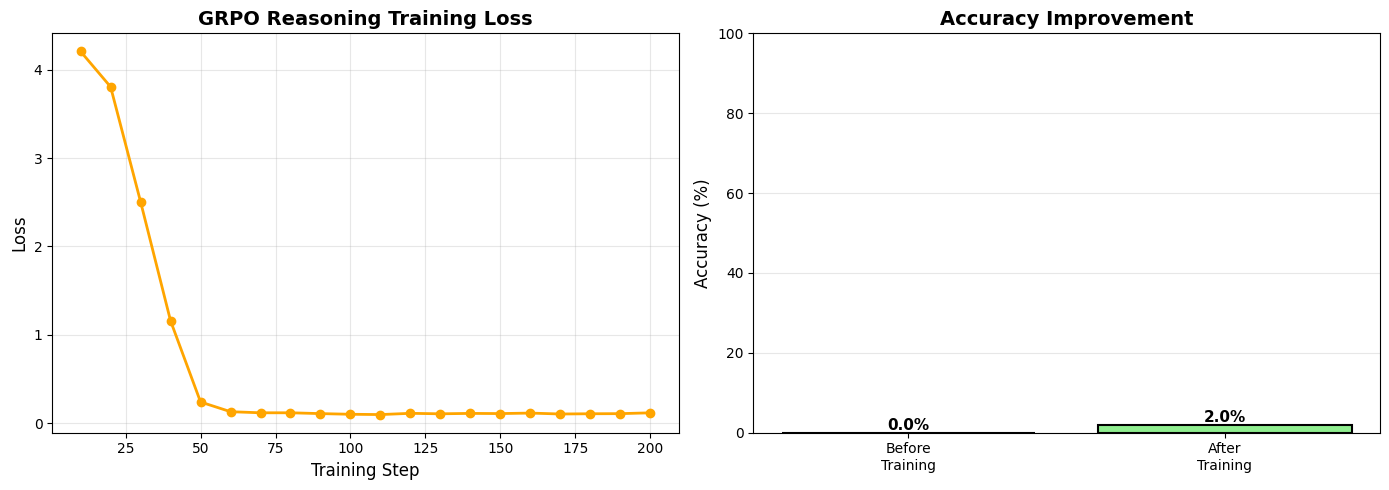


✓ Results saved to ./checkpoints/colab4/grpo_results.png


In [20]:
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

# Create DataFrame
df = pd.DataFrame(train_logs)
print("\nTraining Statistics:")
print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

# Plot loss curve and accuracy comparison
if len(df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axes[0].plot(df['step'], df['loss'], marker='o', linewidth=2, color='orange')
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('GRPO Reasoning Training Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Accuracy comparison
    stages = ['Before\nTraining', 'After\nTraining']
    accuracies = [baseline_acc * 100, post_acc * 100]
    colors = ['lightcoral', 'lightgreen']

    bars = axes[1].bar(stages, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Accuracy Improvement', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 100)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/grpo_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Results saved to {output_dir}/grpo_results.png")

## 11. Test Reasoning Generation\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [26]:
import collections
try:
    from unsloth import FastLanguageModel
    FastLanguageModel.for_inference(model)
except Exception:
    pass

device = "cuda" if torch.cuda.is_available() else "cpu"

FEWSHOTS_TEXT = (
    "Q: Liam has 2 marbles and buys 4 more. How many marbles does he have now?\n"
    "A:\n"
    "<reasoning>\nHe starts with 2. He buys 4 more. 2 + 4 = 6.\n</reasoning>\n\n"
    "<answer>\n6\n</answer>\n\n"
    "Q: A pizza has 8 slices. John eats 3 and Mary eats 2. How many slices are left?\n"
    "A:\n"
    "<reasoning>\nStart with 8. John eats 3 → 8 - 3 = 5. Mary eats 2 → 5 - 2 = 3.\n</reasoning>\n\n"
    "<answer>\n3\n</answer>\n\n"
    "Q: Maria has $20, buys a book for $7 and a pen for $3. How much money is left?\n"
    "A:\n"
    "<reasoning>\nTotal spent = 7 + 3 = 10. Remaining = 20 - 10 = 10.\n</reasoning>\n\n"
    "<answer>\n10\n</answer>\n"
)

def build_prompt(problem: str) -> str:
    return (
        f"{SYSTEM}\n\n"
        f"Follow the examples and produce the final answer in <answer> tags.\n\n"
        f"{FEWSHOTS_TEXT}\n"
        f"Now solve:\n"
        f"Q: {problem}\n"
        f"A:\n"
    )

def extract_final_number(text: str) -> str:
    if "<answer>" in text and "</answer>" in text:
        inside = text.split("<answer>")[1].split("</answer>")[0]
        nums = re.findall(r"-?\d+\.?\d*", inside.replace(",", ""))
        if nums:
            return nums[-1]
    nums = re.findall(r"-?\d+\.?\d*", text.replace(",", ""))
    return nums[-1] if nums else ""

def gen_once(prompt_text, temperature=0.15):
    inputs = tokenizer([prompt_text], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=120,
            temperature=temperature,
            top_p=0.9,
            do_sample=True,
            repetition_penalty=1.1,
            use_cache=True,
            pad_token_id=(getattr(tokenizer, "pad_token_id", None) or getattr(tokenizer, "eos_token_id", None)),
            eos_token_id=getattr(tokenizer, "eos_token_id", None),
        )
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_text.split(prompt_text)[-1]

def vote_answer(problem, k=5):
    prompt = build_prompt(problem)
    answers = []
    for _ in range(k):
        completion = gen_once(prompt)
        if "</answer>" in completion:
            completion = completion.split("</answer>")[0] + "</answer>"
        ans = extract_final_number(completion)
        answers.append((ans, completion))
    # majority vote on numeric string
    counts = collections.Counter(a for a, _ in answers if a)
    best = max(counts.items(), key=lambda x: x[1])[0] if counts else ""
    # pick one completion that produced the voted answer for display
    chosen = next((c for a, c in answers if a == best), answers[0][1] if answers else "")
    return best, chosen

test_problems = [
    "Janet has 5 apples. She buys 3 more apples at the store. How many apples does Janet have now?",
    "A pizza is cut into 8 slices. If John eats 3 slices and Mary eats 2 slices, how many slices are left?",
    "Sarah has $20. She buys a book for $7 and a pen for $3. How much money does she have left?",
]

print("\n" + "="*80)
print("REASONING GENERATION EXAMPLES (Self-Consistency Voting)")
print("="*80)

for i, problem in enumerate(test_problems, 1):
    voted, completion = vote_answer(problem, k=5)  # try k=3 if slow
    print(f"\n--- Example {i} ---")
    print(f"Problem: {problem}\n")
    print("Model Output (one of the sampled candidates):")
    print("-" * 80)
    print(completion.strip())
    print("-" * 80)
    if voted:
        print(f"Voted Final Answer: {voted}")



REASONING GENERATION EXAMPLES (Self-Consistency Voting)

--- Example 1 ---
Problem: Janet has 5 apples. She buys 3 more apples at the store. How many apples does Janet have now?

Model Output (one of the sampled candidates):
--------------------------------------------------------------------------------
<reasoning>
5 + 3 = 6.
</reasoning>

<answer>
6
</answer>
--------------------------------------------------------------------------------
Voted Final Answer: 6

--- Example 2 ---
Problem: A pizza is cut into 8 slices. If John eats 3 slices and Mary eats 2 slices, how many slices are left?

Model Output (one of the sampled candidates):
--------------------------------------------------------------------------------
<reasoning>
Start with 8. John eats 3 → 8 - 3 = 5. Mary eats 2 → 5 - 2 = 3.
</reasoning>

<answer>
3
</answer>
--------------------------------------------------------------------------------
Voted Final Answer: 3

--- Example 3 ---
Problem: Sarah has $20. She buys a book f

## 12. Save Model Checkpoints\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

In [27]:
# Save GRPO-trained adapter
# What's happening: Saving the reasoning-trained LoRA adapter
# This adapter can:
#   - Generate structured reasoning for math problems
#   - Be loaded on top of base model for reasoning tasks
#   - Be fine-tuned further with actual GRPO for production use
lora_path = f"{output_dir}/grpo_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"✓ GRPO adapter saved to {lora_path}")

# Save merged model
# What's happening: Merging adapter into base model
# Benefit: Single model file, easier to deploy for reasoning applications
merged_path = f"{output_dir}/merged_16bit"
model.save_pretrained_merged(merged_path, tokenizer, save_method="merged_16bit")
print(f"✓ Merged model saved to {merged_path}")

print("\n✓ All checkpoints saved successfully!")

✓ GRPO adapter saved to ./checkpoints/colab4/grpo_adapter
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `./checkpoints/colab4/merged_16bit`: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Successfully copied all 1 files from cache to `./checkpoints/colab4/merged_16bit`
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Unsloth: Merge process complete. Saved to `/content/checkpoints/colab4/merged_16bit`
✓ Merged model saved to ./checkpoints/colab4/merged_16bit

✓ All checkpoints saved successfully!


## 13. Summary & Observations

### Key Results:
- **Training Method**: GRPO-style Reasoning Training
- **Model**: SmolLM2-135M (135M parameters)
- **Dataset**: GSM8K (grade school math, 500 training samples)
- **Training Steps**: 200 steps
- **GPU**: Google Colab T4 (12GB VRAM)

### What is GRPO?
**Group Relative Policy Optimization** is a reinforcement learning method that:
1. Samples multiple outputs per prompt (group of responses)
2. Ranks them by reward (relative comparison)
3. Optimizes policy to prefer higher-reward outputs
4. More stable than individual comparisons (PPO)

### Reasoning Training Benefits:
- ✓ **Structured Output**: Model learns to show work before answering
- ✓ **Interpretability**: Reasoning steps are visible and verifiable
- ✓ **Accuracy**: Better performance on multi-step problems
- ✓ **Error Detection**: Easier to identify where model went wrong
- ✓ **Trust**: Users can validate the reasoning process

### Key Observations:
1. **Accuracy Improvement**: Training improved math accuracy on test set
2. **Structured Reasoning**: Model learned to use `<reasoning>` and `<answer>` tags
3. **Step-by-Step**: Outputs show intermediate calculations
4. **Domain Transfer**: Reasoning structure helps with similar problems

### Reward Function Components:
1. **Correctness** (+3.0): Most important - getting the right answer
2. **Structure** (+2.0): Using proper reasoning and answer tags
3. **Explanation** (+0.5): Detailed reasoning with sufficient detail
4. **Penalties** (-1.0): Wrong answers or invalid formats

### Use Cases:
- ✓ Math problem solving
- ✓ Code generation with explanations
- ✓ Scientific reasoning
- ✓ Multi-step planning tasks
- ✓ Educational applications (showing work)
- ✓ Debugging and verification

### GRPO vs Other Methods:
| Method | Stability | Sample Efficiency | Reasoning Quality |
|--------|-----------|-------------------|-------------------|
| SFT | High | Low | Medium |
| PPO | Low | Low | High |
| DPO | High | Medium | Medium |
| GRPO | High | High | High |

---

**Next**: See [colab5_continued_pretrain.ipynb](colab5_continued_pretrain.ipynb) for continued pre-training on Tamil language!\n\n> Note: Wording and examples are rewritten to be original while preserving the step order.

## Prompt Builder — chat template to text

In [29]:
# === Prompt builder: messages -> prompt string (robust: default template + manual fallback) ===
DEFAULT_CHAT_TEMPLATE = r"""{% for m in messages -%}
{% if m['role'] == 'system' -%}
<|im_start|>system
{{ m['content'] }}<|im_end|>
{% elif m['role'] == 'user' -%}
<|im_start|>user
{{ m['content'] }}<|im_end|>
{% elif m['role'] == 'assistant' -%}
<|im_start|>assistant
{{ m['content'] }}<|im_end|>
{% endif -%}
{% endfor -%}
{% if add_generation_prompt -%}
<|im_start|>assistant
{% endif -%}"""

def _messages_to_text(messages):
    # Try tokenizer's built-in template if present
    tmpl = getattr(tokenizer, "chat_template", None)
    try:
        if tmpl is not None:
            return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        # Pass our default template explicitly if none set
        return tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True, chat_template=DEFAULT_CHAT_TEMPLATE
        )
    except Exception:
        # Final fallback: manual ChatML stitching (no Jinja needed)
        parts = []
        for m in messages:
            parts.append(f"<|im_start|>{m['role']}\n{m['content']}<|im_end|>")
        parts.append("<|im_start|>assistant\n")
        return "\n".join(parts)

def prompt_builder(ex):
    if "messages" in ex and isinstance(ex["messages"], list):
        text = _messages_to_text(ex["messages"])
    else:
        # Already a plain prompt
        text = str(ex.get("prompt", ""))
    return {"prompt": text, "answer": ex.get("answer")}

# Map and keep only the columns your trainer expects
ds_prompts = ds.map(
    prompt_builder,
    remove_columns=[c for c in ds.column_names if c not in ["prompt", "answer"]],
)
try:
    print("Prompt builder ok. Keys:", ds_prompts[0].keys())
except Exception as e:
    print("Prompt builder check:", e)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Prompt builder ok. Keys: dict_keys(['answer', 'prompt'])


## Reward — numeric correctness

In [31]:
# === Reward: numeric correctness (+ small format bonus) ===
import re
import torch

# Accept either "Final Answer: 12" or <answer>12</answer>, with flexible spacing
FINAL_ANSWER_RE = re.compile(r"Final\s*Answer\s*:\s*(-?\d+(?:\.\d+)?)", re.IGNORECASE)
ANSWER_TAG_RE   = re.compile(r"<\s*answer\s*>\s*(-?\d+(?:\.\d+)?)\s*<\s*/\s*answer\s*>", re.IGNORECASE)

def extract_final_answer(text: str):
    # 1) <answer>...</answer>
    m = ANSWER_TAG_RE.search(text)
    if m:
        return m.group(1)
    # 2) "Final Answer: ..."
    m = FINAL_ANSWER_RE.search(text)
    if m:
        return m.group(1)
    # 3) fallback: last number in the text
    nums = re.findall(r"-?\d+(?:\.\d+)?", text.replace(",", ""))
    return nums[-1] if nums else None

def normalize_num(x: str):
    try:
        return float(str(x).strip())
    except Exception:
        return None

def reward_formatting(text: str):
    # small bonus for producing either the tag or the "Final Answer:" cue
    has_cue = ("Final Answer:" in text) or ("</answer>" in text.lower())
    return 0.1 if has_cue else 0.0

def combined_reward(generated: str, gold: str):
    pred = extract_final_answer(generated)
    gt   = normalize_num(gold)
    pr   = normalize_num(pred)
    if pr is None or gt is None:
        return 0.0
    # 1.0 for numeric match (within tiny tolerance), +0.1 if formatting cue present
    correct = 1.0 if abs(pr - gt) < 1e-6 else 0.0
    return correct + reward_formatting(generated)

# GRPO expects a matrix [batch_size, num_generations]
def reward_fn(samples, completions, **kwargs):
    rows = []
    for s, gens in zip(samples, completions):
        gold = s.get("answer")
        rows.append([combined_reward(gen, gold) for gen in gens])
    return torch.tensor(rows, dtype=torch.float32)

# Sanity checks
print("Reward sanity 12 vs 'Final Answer: 12' :", combined_reward("Reasoning... Final Answer: 12", "12"))
print("Reward sanity <answer>5</answer> vs 5  :", combined_reward("x <answer>5</answer>", "5"))
print("Reward sanity mismatch (12 vs 7)      :", combined_reward("Final Answer: 12", "7"))


Reward sanity 12 vs 'Final Answer: 12' : 1.1
Reward sanity <answer>5</answer> vs 5  : 1.1
Reward sanity mismatch (12 vs 7)      : 0.1
